In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to Generative Adversarial Networks (GANs)

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture.

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN.



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [90]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [91]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [92]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

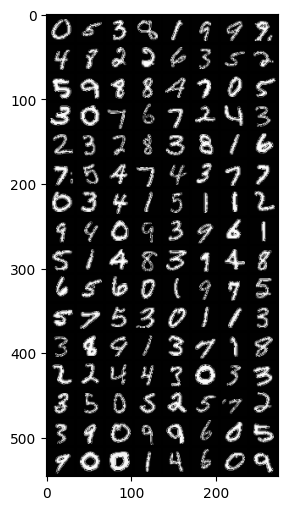

In [93]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm
- ReLU

In [94]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    layers = []
    layers.append(nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias=False))
    if not last_layer:
        layers.append(nn.BatchNorm2d(channels_out))
        layers.append(nn.ReLU(inplace=True))
    else:
        layers.append(nn.Tanh())
    
    return nn.Sequential(*layers)

In [95]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()


        self.model = nn.Sequential(
            # Reshape z [128,1000] into [n_batch, n_z, 1, 1]
            nn.Unflatten(dim=1, unflattened_size=(nz, 1, 1)),
            
            # First upscaling block -> [n_batch, ngf*4, 4, 4]
            get_upscaling_block(nz, ngf*4, kernel=4, stride=1, padding=0),
            
            # Second upscaling block -> [n_batch, ngf*2, 8, 8]
            get_upscaling_block(ngf*4, ngf*2, kernel=4, stride=2, padding=1),
            
            # Third upscaling block -> [n_batch, ngf, 16, 16]
            get_upscaling_block(ngf*2, ngf, kernel=4, stride=2, padding=1),
            
            # Fourth (and last) upscaling block -> [n_batch, 1, 32, 32]
            get_upscaling_block(ngf, nchannels, kernel=4, stride=2, padding=1, last_layer=True)
        )

    def forward(self, z):
        # print(z.shape)
        # Done in the nn.Sequential model with Unflatten 
        # x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        # print(x.shape)
        print("xshape", z.shape)
        return self.model(z)


### 2.1.3. Sanity Tests

In [96]:
nz = 1000
z = torch.randn(batch_size, nz)
z.shape

torch.Size([128, 1000])

In [97]:
G = Generator(nz=nz, ngf=16)
G.model
G(z).shape

xshape torch.Size([128, 1000])


torch.Size([128, 1, 32, 32])

In [98]:
# G = Generator(nz=nz, ngf=16)
# assert G(z).shape == (batch_size, 1, 32, 32)

# G = Generator(nz=nz, ngf=16)
# assert G(z).shape == (batch_size, 1, 32, 32)

In [99]:
# # visualize the output - at first it should just look like random noise!!
# x_fake = G(z)
# plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator.

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]`

In [100]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    layers = []
    layers.append(nn.Conv2d(channels_in, channels_out, kernel, stride, padding))
    
    if is_last:
        layers.append(nn.Sigmoid())
    elif not use_batch_norm:
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    else:
        layers.append(nn.BatchNorm2d(channels_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    
    return nn.Sequential(*layers)

In [101]:
class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()

        self.model = nn.Sequential(
            # Convolution (32 filters, kernel 4, stride 2, padding 1, no bias) + Batch Norm + LeakyReLU (α = 0.2)
            get_downscaling_block(nchannels, ndf, kernel=4, stride=2, padding=1, use_batch_norm=True),
            # Convolution (64 filters, kernel 4, stride 2, padding 1, no bias) + Batch Norm + LeakyReLU (α = 0.2)
            get_downscaling_block(ndf, ndf*2, kernel=4, stride=2, padding=1, use_batch_norm=True),
            # Convolution (128 filters, kernel 4, stride 2, padding 1, no bias) + Batch Norm + LeakyReLU (α = 0.2)
            get_downscaling_block(ndf*2, ndf*4, kernel=4, stride=2, padding=1, use_batch_norm=True),
            # Convolution (1 filter, kernel 4, stride 1, padding 0, no bias) + Sigmoid activation
            get_downscaling_block(ndf*4, 1, kernel=4, stride=1, padding=0, is_last=True, use_batch_norm=False),
        )


    def forward(self, x):
        print("discr x forward",x.shape)
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions --> TODO: it can be done with Unflatten as in the generator

### 2.2.3 Sanity Checking

In [102]:
real_batch, real_labels = next(iter(dataloader))

In [103]:
D = Discriminator(ndf=32, nchannels=1)
print("d real shape", D(real_batch).shape)
print(real_batch.shape)
assert D(real_batch).shape == (real_batch.shape[0], 1)

discr x forward torch.Size([128, 1, 32, 32])
d real shape torch.Size([128, 1])
torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


# 3. Training

## 3.1 Loss
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [104]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions.
1. First, we need to continuously sample z from a Gaussian distribution.
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s.

In [105]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label (real labels)
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label (fake labels)
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [106]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training!
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve.
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

0it [00:00, ?it/s]

it: 0; g_loss: 0.8417604565620422; d_loss: 1.5318033695220947; avg_real_score: 0.594943642616272; avg_fake_score: 0.4481968879699707: : 0it [00:00, ?it/s]

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
torch.Size([64, 100])
Sequential(
  (0): Unflatten(dim=1, unflattened_size=(100, 1, 1))
  (1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (4): Sequenti

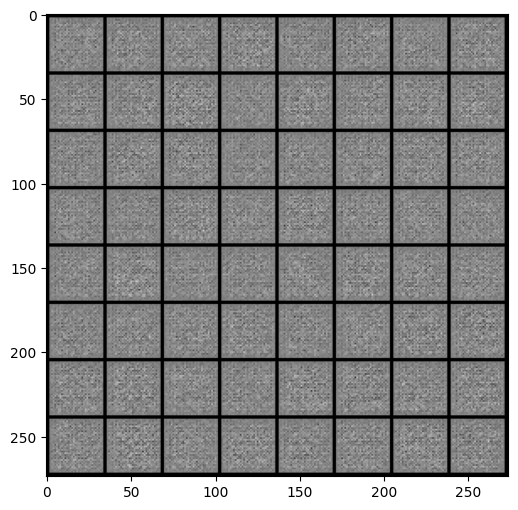

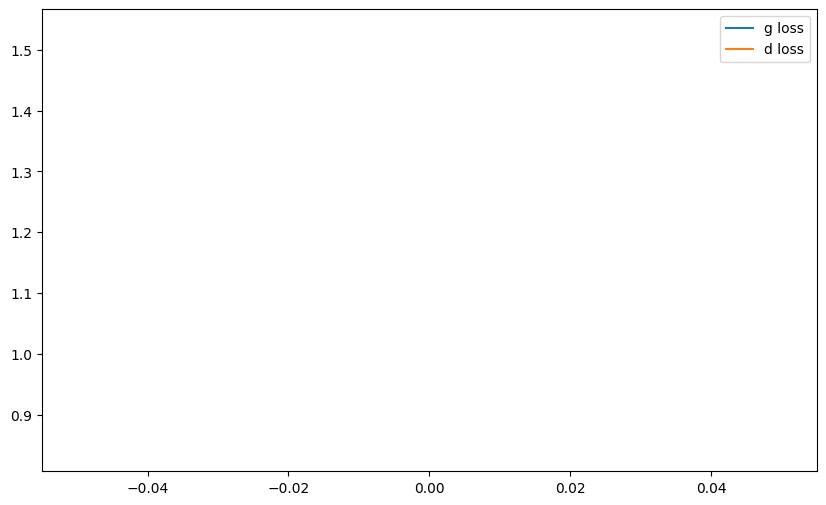

it: 4; g_loss: 0.9154286980628967; d_loss: 1.5980448722839355; avg_real_score: 0.7477301955223083; avg_fake_score: 0.41430145502090454: : 5it [00:00,  9.36it/s]

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 8; g_loss: 1.4995745420455933; d_loss: 1.1369341611862183; avg_real_score: 0.7345293760299683; avg_fake_score: 0.2335623800754547: : 9it [00:00, 13.35it/s] 

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 12; g_loss: 1.5795726776123047; d_loss: 1.0639829635620117; avg_real_score: 0.7763574123382568; avg_fake_score: 0.21936902403831482: : 13it [00:01, 15.43it/s]

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 16; g_loss: 1.6562139987945557; d_loss: 1.0741387605667114; avg_real_score: 0.7567431926727295; avg_fake_score: 0.2038879543542862: : 17it [00:01, 16.58it/s] 

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 20; g_loss: 2.120774269104004; d_loss: 0.9141919016838074; avg_real_score: 0.729327917098999; avg_fake_score: 0.13052724301815033: : 21it [00:01, 17.15it/s]  

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 24; g_loss: 2.338947296142578; d_loss: 0.7592282295227051; avg_real_score: 0.7234538793563843; avg_fake_score: 0.10305146872997284: : 25it [00:01, 17.36it/s] 

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 28; g_loss: 2.4957115650177; d_loss: 0.7040581703186035; avg_real_score: 0.711264967918396; avg_fake_score: 0.08809889853000641: : 29it [00:02, 17.50it/s]    

discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


it: 29; g_loss: 2.5138607025146484; d_loss: 0.6583242416381836; avg_real_score: 0.73622727394104; avg_fake_score: 0.08597718179225922: : 30it [00:02, 14.07it/s]


discr x forward torch.Size([128, 1, 32, 32])
xshape torch.Size([128, 100])
y fake torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])
discr x forward torch.Size([128, 1, 32, 32])


KeyboardInterrupt: 

In [107]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:

        # 1. construct a batch of real samples from the training set (sample a z vector)
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device) # real image
        cur_batch_size = im.shape[0] # batch size
        z = sample_z(cur_batch_size, nz)
        # label_real = torch.full((cur_batch_size,), 1., dtype=torch.float, device=device)
        label_real= get_labels_one(cur_batch_size).view(-1)

        # 2. forward pass through D (=Classify real image with D)
        yhat_real = netD(im).view(-1) # the size -1 is inferred from other dimensions

        # 3. forward pass through G (=Generate fake image batch with G)
        y_fake = netG(z)
        # label_fake=label_real.fill_(0.)
        label_fake= get_labels_zero(cur_batch_size).view(-1)

        # 4. Classify fake image with D
        print("y fake", y_fake.shape )
        yhat_fake = netD(y_fake.detach()).view(-1)

        ### Discriminator
        d_loss = criterion(yhat_real,label_real) + criterion(yhat_fake,label_fake) # TODO check loss
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ### Generator
        # Since we just updated D, perform another forward pass of all-fake batch through D
        yhat_fake = netD(y_fake).view(-1)
        g_loss = criterion(yhat_fake, label_real) # fake labels are real for generator cost
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:
            
            print(z_test.shape)
            print(netG.model)
            fake_im = netG(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [145]:
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()

        # Transpose Convolution (256 filters, kernel 4, stride 1, padding 0, no bias) + Batch Norm + ReLU
        self.upscaling_z = get_upscaling_block(nz, ngf*16, kernel=4, stride=1, padding=0) # branch 1
        self.upscaling_c = get_upscaling_block(nc, ngf*16, kernel=4, stride=1, padding=0) # branch 2

        self.rest_model = nn.Sequential(
            # Concatenate branches 1 and 2 (256 + 256 channels)
            get_upscaling_block(ngf*16 + ngf*16, ngf*16, kernel=4, stride=2, padding=1),
            # Transpose Convolution (128 filters, kernel 4, stride 2, padding 1, no bias) + Batch Norm + ReLU
            get_upscaling_block(ngf*16, ngf*8, kernel=4, stride=2, padding=1),
            # Transpose Convolution (1 filter, kernel 4, stride 2, padding 1, no bias)
            get_upscaling_block(ngf*8, nchannels, kernel=4, stride=2, padding=1, last_layer=True)
        )

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)
        
        x = self.upscaling_z(x)
        y = self.upscaling_c(y)
        
        combined = torch.cat([x, y], 1)
        return self.rest_model(combined)

### 4.1.2 Discriminator

In [146]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)


        self.rest = nn.Sequential(
            get_downscaling_block(ndf*2 + ndf*2, ndf*8, kernel=4, stride=2, padding=1, use_batch_norm=True),
            get_downscaling_block(ndf*8, ndf*16, kernel=4, stride=2, padding=1, use_batch_norm=True),
            get_downscaling_block(ndf*16, 1, kernel=4, stride=1, padding=0, is_last=True, use_batch_norm=False),
        )


    def forward(self, x, y):
        #Expansion of y into a tensor sized 10 × 32 × 32
        y = y.unsqueeze(2).unsqueeze(2).expand(-1, -1, x.shape[2], x.shape[3])
        x = self.downscale_x(x)
        y = self.downscale_y(y)
        # Concatenate the two feature maps along the channel dimension
        combined = torch.cat([x, y], dim=1)

        return self.rest(combined).squeeze(1).squeeze(1) # remove spatial dimensions



### 4.1.3 Sanity Checks

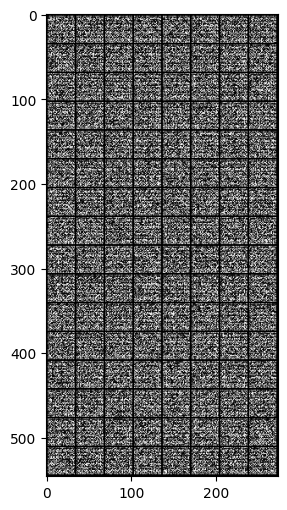

In [147]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
assert cG(z,y).shape == (batch_size, 1, 32, 32)

x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [148]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
print(cD.rest)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

Sequential(
  (0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): Sigmoid()
  )
)


## 4.2 Training

In [149]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 5.7175374031066895; d_loss: 1.7048838138580322; avg_real_score: 0.7126123905181885; avg_fake_score: 0.03436066955327988: : 0it [00:00, ?it/s]

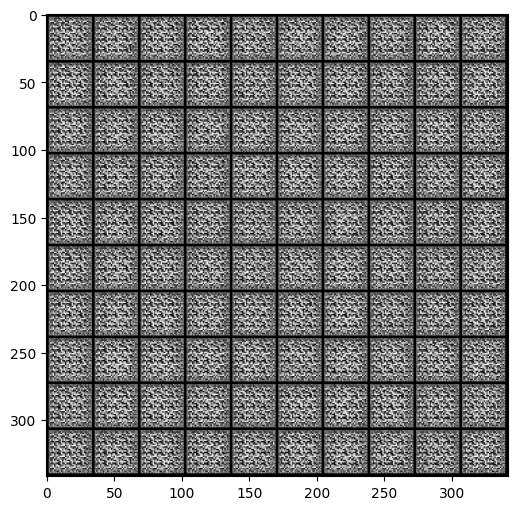

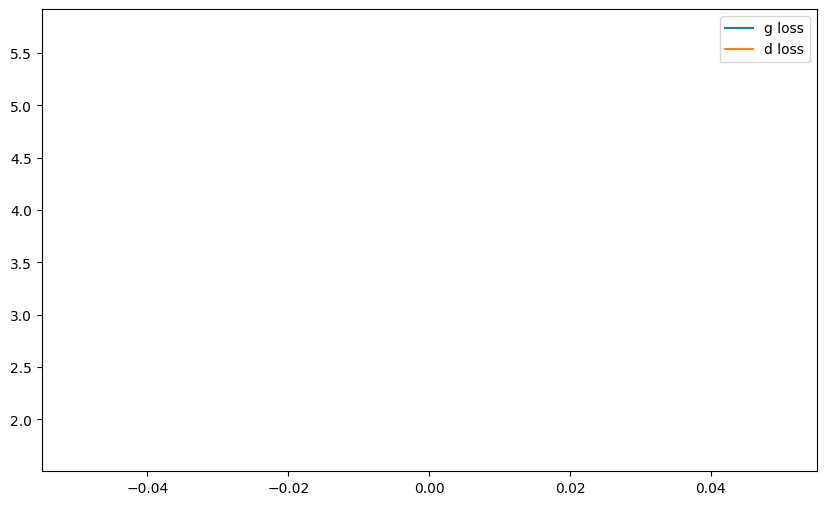

it: 200; g_loss: 2.047884464263916; d_loss: 0.7930586338043213; avg_real_score: 0.7413562536239624; avg_fake_score: 0.14097712934017181: : 200it [00:38,  5.06it/s]  

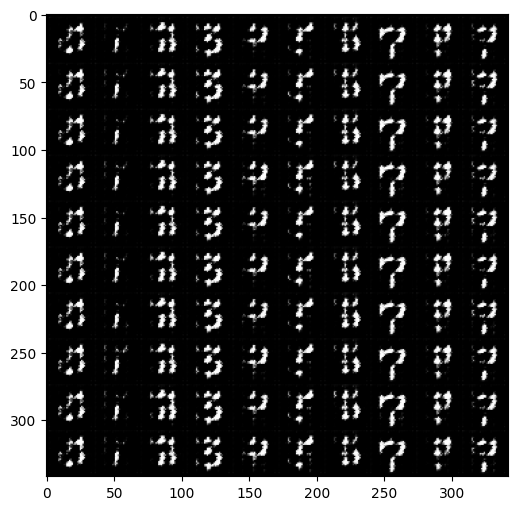

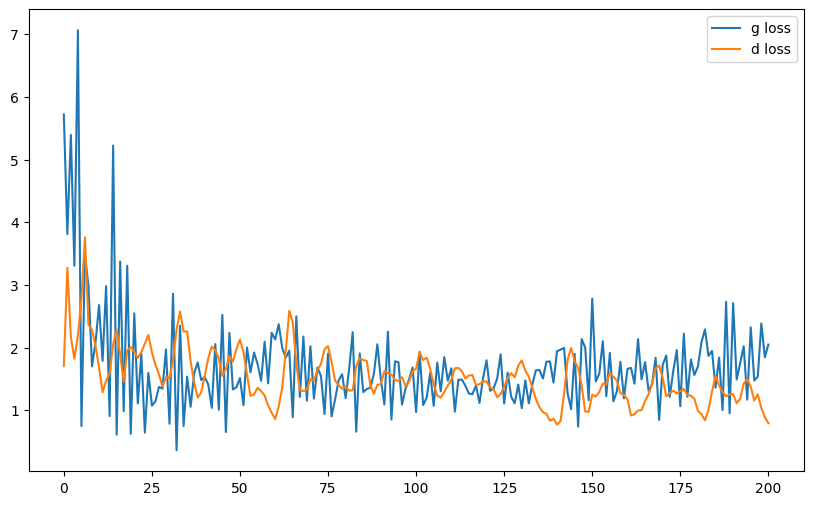

it: 306; g_loss: 1.5894169807434082; d_loss: 0.984126627445221; avg_real_score: 0.5529323816299438; avg_fake_score: 0.23686406016349792: : 307it [01:00,  5.10it/s]  


KeyboardInterrupt: 

In [150]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing

for epoch in range(nb_epochs):
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)
        y = F.one_hot(labels).float().to(device)
        cur_batch_size = im.shape[0]
        z = sample_z(cur_batch_size, nz)
        # label_real = torch.full((cur_batch_size,), 1., dtype=torch.float, device=device)
        label_real= get_labels_one(cur_batch_size).view(-1)

        # 2. forward pass through D (=Classify real image with D)
        yhat_real = netD(im,y).view(-1) # the size -1 is inferred from other dimensions

        # 3. forward pass through G (=Generate fake image batch with G)
        y_fake = netG(z, y)
        # label_fake=label_real.fill_(0.)
        label_fake= get_labels_zero(cur_batch_size).view(-1)

        # 4. Classify fake image with D
        yhat_fake = netD(y_fake.detach(), y).view(-1)

        ### Discriminator
        d_loss = criterion(yhat_real,label_real) + criterion(yhat_fake,label_fake) # TODO check loss
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()


        ### Generator
        # Since we just updated D, perform another forward pass of all-fake batch through D
        yhat_fake = netD(y_fake, y).view(-1)
        g_loss = criterion(yhat_fake, label_real) # fake labels are real for generator cost
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        # Save Metrics
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1


## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

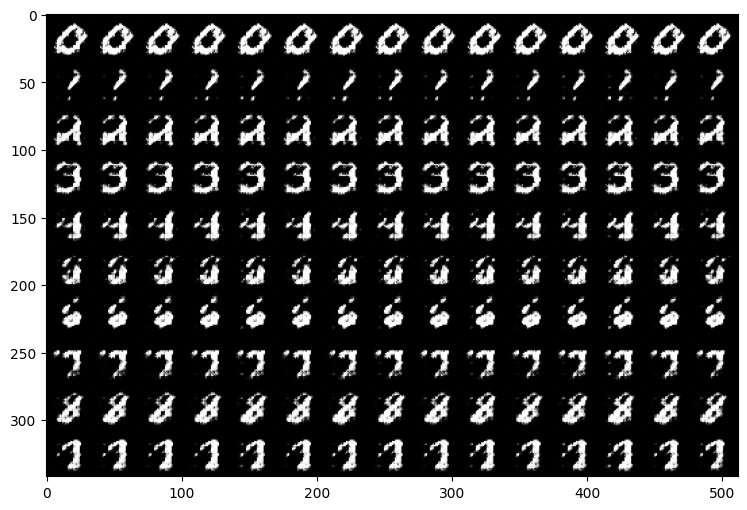

In [151]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
